Dataset :- https://www.kaggle.com/gti-upm/leapgestrecog

In [ ]:
from google.colab import drive
import zipfile
import os
import random
import math
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Google Drive path
zip_path = '/content/drive/MyDrive/Hand_gesture.zip'
# Directory to extract to
extract_path = '/content/Hand_gesture_dataset'

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Files extracted successfully.")
else:
    print("Files already extracted.")


Files already extracted.


In [ ]:
images = []
labels = []
for directory in os.listdir(extract_path):
  for subDir in os.listdir(os.path.join(extract_path,directory)):
    for subsubDir in os.listdir(os.path.join(extract_path,directory,subDir)):
      for img in os.listdir(os.path.join(extract_path, directory, subDir,subsubDir)):
        img_path = os.path.join(extract_path, directory, subDir, subsubDir, img)
        images.append(img_path)
        labels.append(subsubDir)

In [ ]:
print(images[:5])
print(labels[:5])

['/content/Hand_gesture_dataset/leapGestRecog/06/10_down/frame_06_10_0188.png', '/content/Hand_gesture_dataset/leapGestRecog/06/10_down/frame_06_10_0130.png', '/content/Hand_gesture_dataset/leapGestRecog/06/10_down/frame_06_10_0199.png', '/content/Hand_gesture_dataset/leapGestRecog/06/10_down/frame_06_10_0189.png', '/content/Hand_gesture_dataset/leapGestRecog/06/10_down/frame_06_10_0055.png']
['10_down', '10_down', '10_down', '10_down', '10_down']


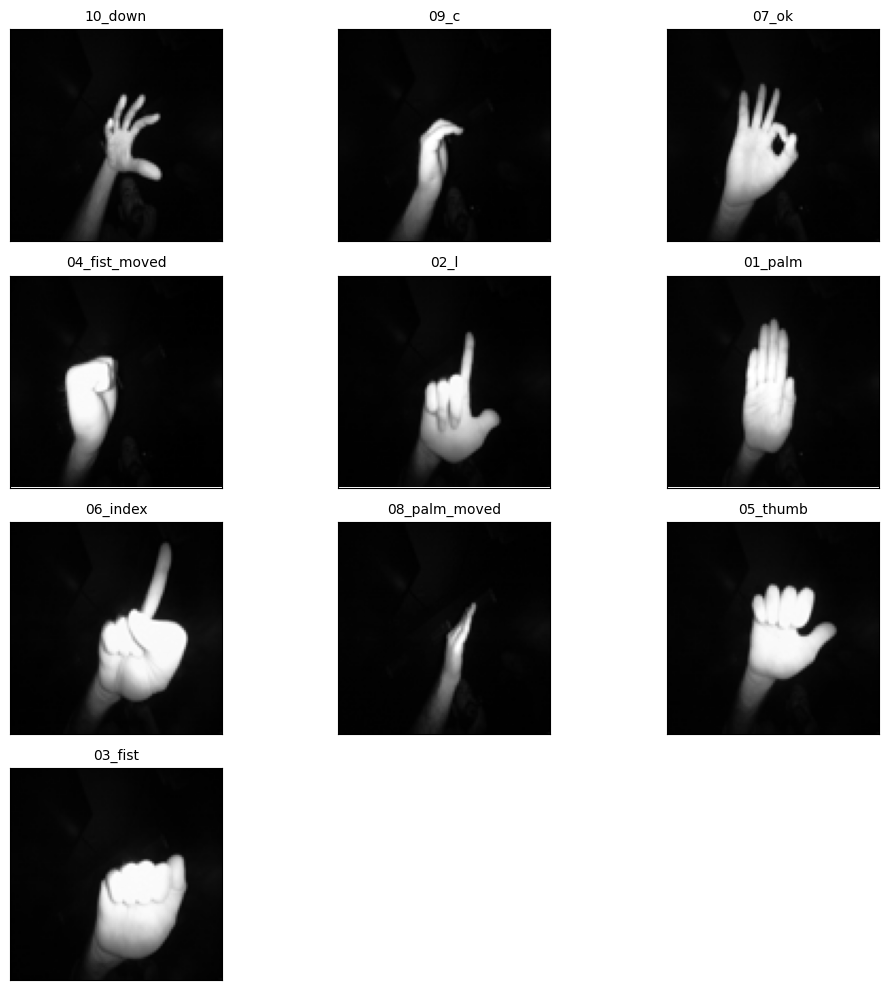

In [ ]:
def plot_one_image_per_label(image_paths, labels, img_size=(100, 100)):
    label_to_image = {}

    # Loop through all images and store one random image path for each label
    for img_path, label in zip(image_paths, labels):
        if label not in label_to_image:
            label_to_image[label] = img_path

    unique_labels = list(label_to_image.keys())
    num_labels = len(unique_labels)

    cols = 3
    rows = math.ceil(num_labels / cols)  #grid size

    plt.figure(figsize=(10, 10))
    for i, label in enumerate(unique_labels):
        plt.subplot(rows, cols, i + 1)
        img_path = label_to_image[label]
        with Image.open(img_path) as img:
            img = img.resize(img_size)
            img_array = np.array(img)
        # Plot the image
        plt.imshow(img_array, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.title(label, fontsize=10)
    plt.tight_layout()
    plt.show()

plot_one_image_per_label(images, labels)


In [ ]:
img_size = (100, 100)
X = []

for img_path in images:
    # Open the image file
    try:
        with Image.open(img_path) as img:
            img = img.resize(img_size)
            img_array = np.array(img)
            img_array = img_array / 255.0
            img_array = np.expand_dims(img_array, axis=-1)  #channel dimension
            X.append(img_array)   #processed images
    except Exception as e:
        print(f"Error processing file {img_path}: {e}")

X = np.array(X)
print(X.shape)


(20000, 100, 100, 1)


In [ ]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)
y = to_categorical(y_encoded)
print("Label classes:", label_encoder.classes_)

Label classes: ['01_palm' '02_l' '03_fist' '04_fist_moved' '05_thumb' '06_index' '07_ok'
 '08_palm_moved' '09_c' '10_down']


In [ ]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (16000, 100, 100, 1)
X_test shape: (4000, 100, 100, 1)


In [ ]:
X_train[1,:]

array([[[0.01960784],
        [0.01960784],
        [0.01960784],
        ...,
        [0.01568627],
        [0.01568627],
        [0.01568627]],

       [[0.01960784],
        [0.01960784],
        [0.01960784],
        ...,
        [0.01568627],
        [0.01568627],
        [0.01568627]],

       [[0.01960784],
        [0.01960784],
        [0.01960784],
        ...,
        [0.01568627],
        [0.01568627],
        [0.01568627]],

       ...,

       [[0.02352941],
        [0.02352941],
        [0.01960784],
        ...,
        [0.01960784],
        [0.01960784],
        [0.01960784]],

       [[0.01960784],
        [0.01960784],
        [0.02352941],
        ...,
        [0.01568627],
        [0.01568627],
        [0.01568627]],

       [[0.01960784],
        [0.01960784],
        [0.01960784],
        ...,
        [0.01568627],
        [0.02745098],
        [0.04705882]]])

In [ ]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
500/500 [==============================] - 314s 624ms/step - loss: 0.3674 - accuracy: 0.8744 - val_loss: 0.0099 - val_accuracy: 0.9973
Epoch 2/10
500/500 [==============================] - 313s 626ms/step - loss: 0.0504 - accuracy: 0.9844 - val_loss: 0.0054 - val_accuracy: 0.9980
Epoch 3/10
500/500 [==============================] - 315s 629ms/step - loss: 0.0291 - accuracy: 0.9906 - val_loss: 8.1750e-04 - val_accuracy: 0.9998
Epoch 4/10
500/500 [==============================] - 309s 619ms/step - loss: 0.0245 - accuracy: 0.9918 - val_loss: 0.0026 - val_accuracy: 0.9990
Epoch 5/10
500/500 [==============================] - 335s 670ms/step - loss: 0.0227 - accuracy: 0.9924 - val_loss: 0.0058 - val_accuracy: 0.9980
Epoch 6/10
500/500 [==============================] - 317s 634ms/step - loss: 0.0174 - accuracy: 0.9937 - val_loss: 4.0534e-04 - val_accuracy: 1.0000
Epoch 7/10
500/500 [==============================] - 313s 626ms/step - loss: 0.0135 - accuracy: 0.9954 - val_loss: 

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 128)       0

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy}")
print(f"Loss: {loss}")

125/125 [==============================] - 18s 148ms/step - loss: 2.8645e-05 - accuracy: 1.0000
Test accuracy: 1.0
Loss: 2.8644852136494592e-05


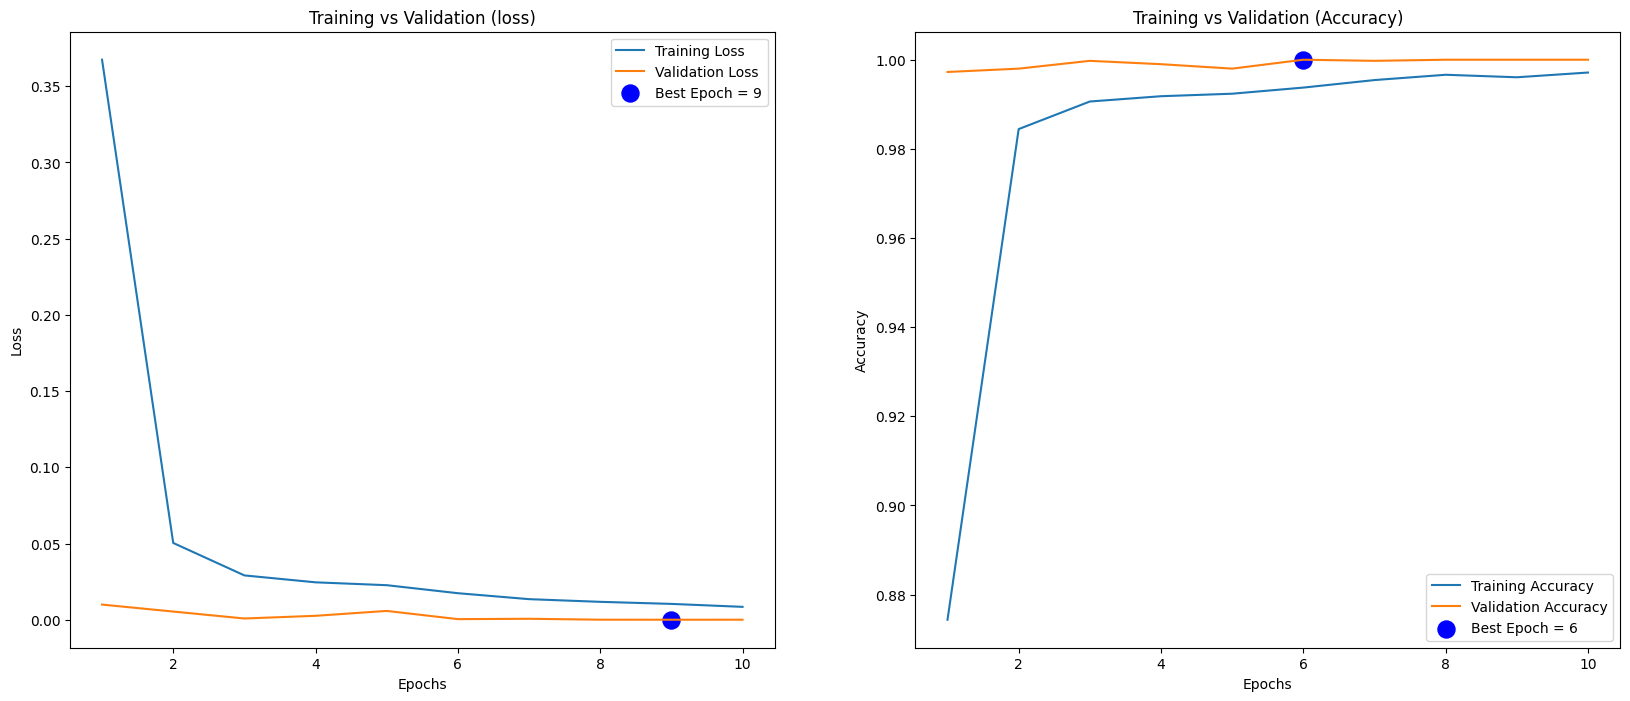

In [ ]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)

val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_label = f'Best Epoch = {str(index_acc + 1)}'

plt.figure(figsize= (20,8))

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , label = 'Training Loss')
plt.plot(Epochs , val_loss , label = 'Validation Loss')
plt.scatter(index_loss +1 , val_lowest , s = 150 , c = 'blue' , label = loss_label)
plt.title('Training vs Validation (loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , label= 'Training Accuracy')
plt.plot(Epochs , val_acc , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s= 150 , c = 'blue' , label= acc_label)
plt.title('Training vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show();

In [ ]:
# Predict the labels for the test set
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1) #convert probabilities to class labels
true_labels = np.argmax(y_test, axis=1)  #covert encoded y_test to class labels

print("First few predictions:", predicted_labels[:10])
print("First few true labels:", true_labels[:10])


125/125 [==============================] - 21s 162ms/step
First few predictions: [3 9 3 0 2 2 0 0 4 9]
First few true labels: [3 9 3 0 2 2 0 0 4 9]


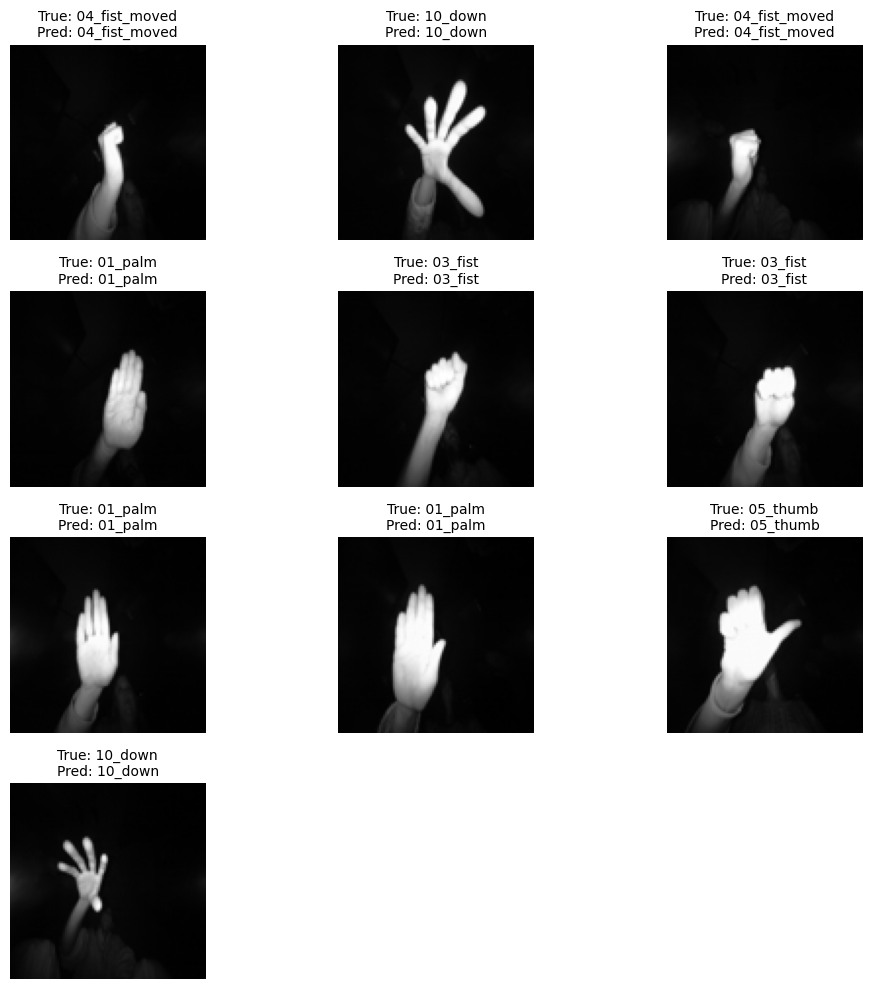

In [ ]:
def plot_sample(ax, image, true_label, pred_label):
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(f"True: {label_encoder.classes_[true_label]}\nPred: {label_encoder.classes_[pred_label]}", fontsize=10)
    ax.axis('off')

num_samples = 10
num_columns = 3

num_rows = (num_samples + num_columns - 1) // num_columns  # number of rows
fig, axes = plt.subplots(num_rows, num_columns,figsize=(10,10))

axes = axes.flatten() # Flatten axes array for easier iteration

for i in range(num_samples):
    plot_sample(axes[i], X_test[i], np.argmax(y_test[i]), predicted_labels[i])

for j in range(num_samples, len(axes)):  # Remove unused subplots
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
